In [1]:
import pandas as pd
from datetime import datetime, timedelta

In [2]:
root_path = './dataset/'

In [3]:
comportamiento_df = pd.read_csv(f'{root_path}comportamiento_tarjetasvisa.csv', sep = ',')

In [4]:
informacion_df = pd.read_csv(f'{root_path}informacion_adicional_tarjetas.csv', sep = ',')

In [5]:
comportamiento_df['ID_CLIENTE'].value_counts().shape[0]

45985

### Definición de mal pagador

In [6]:
comportamiento_df.drop_duplicates()
comportamiento_df

,ID_CLIENTE,MESES,DIAS_VENCIDOS
0,5001711,0,NaN
1,5001711,-1,11.0
2,5001711,-2,16.0
3,5001711,-3,16.0
4,5001712,0,0.0
...,...,...,...
1048570,5150487,-25,0.0
1048571,5150487,-26,0.0
1048572,5150487,-27,0.0
1048573,5150487,-28,0.0


In [7]:
comportamiento_df.isnull().sum()

ID_CLIENTE            0
MESES                 0
DIAS_VENCIDOS    209230
dtype: int64

##### 20% de las observaciones son nulas en columna DIAS_VENCIDOS

In [8]:
grupo_df = comportamiento_df.groupby(["ID_CLIENTE","MESES"]).max()
grupo_df

DIAS_VENCIDOS
ID_CLIENTE MESES               
5001711    -3              16.0
           -2              16.0
           -1              11.0
            0               NaN
5001712    -18             17.0
...                         ...
5150487    -4               0.0
           -3               0.0
           -2               0.0
           -1               0.0
            0               0.0

[1048575 rows x 1 columns]

In [9]:
filtro_nulos = comportamiento_df.groupby('ID_CLIENTE').filter(lambda x:x['DIAS_VENCIDOS'].isnull().any())
filtro_nulos['ID_CLIENTE'].value_counts()

5059942    61
5005201    61
5002806    61
5105565    61
5017058    61
           ..
5047681     1
5021959     1
5125464     1
5092092     1
5137027     1
Name: ID_CLIENTE, Length: 25005, dtype: int64

In [10]:
comportamiento_df['ID_CLIENTE'].value_counts()

5016769    61
5002806    61
5118192    61
5145767    61
5078567    61
           ..
5028795     1
5148442     1
5053900     1
5046332     1
5079047     1
Name: ID_CLIENTE, Length: 45985, dtype: int64

##### De un total de 45,985 clientes con comportamiento del manejo de tarjeta, 25,005 clientes tienen al menos un campo nulo en dias vencidos.

##### Se consideran todas las observaciones para definir el tipo de pagador toda vez que podemos asegurar un mal comportamiento con información cierta.

##### Score de comportamiento:
Mayor que 25 y menor igual que 30, se puntúa el comportamiento con 0.25.
Mayor que 30, se puntúa con 1.

In [11]:
# funcion para score comportamiento
def score_comportamiento(dias_vencidos):
    if dias_vencidos > 25 and dias_vencidos <= 30:
        return 0.25
    elif dias_vencidos > 30:
        return 1
    else:
        return 0

In [12]:
comportamiento_df['SCORE'] = comportamiento_df['DIAS_VENCIDOS'].apply(score_comportamiento)
comportamiento_df['MESES_ANTIGUEDAD'] = (comportamiento_df.groupby('ID_CLIENTE')['MESES'].transform('min')) * (-1)
comportamiento_df

,ID_CLIENTE,MESES,DIAS_VENCIDOS,SCORE,MESES_ANTIGUEDAD
0,5001711,0,NaN,0.0,3
1,5001711,-1,11.0,0.0,3
2,5001711,-2,16.0,0.0,3
3,5001711,-3,16.0,0.0,3
4,5001712,0,0.0,0.0,18
...,...,...,...,...,...
1048570,5150487,-25,0.0,0.0,29
1048571,5150487,-26,0.0,0.0,29
1048572,5150487,-27,0.0,0.0,29
1048573,5150487,-28,0.0,0.0,29


In [13]:
calificacion_df = comportamiento_df[["ID_CLIENTE","MESES_ANTIGUEDAD","SCORE"]].groupby(["ID_CLIENTE","MESES_ANTIGUEDAD"]).sum().reset_index()
calificacion_df

,ID_CLIENTE,MESES_ANTIGUEDAD,SCORE
0,5001711,3,0.00
1,5001712,18,0.25
2,5001713,21,0.00
3,5001714,14,0.00
4,5001715,59,0.00
...,...,...,...
45980,5150482,28,0.25
45981,5150483,17,0.00
45982,5150484,12,0.50
45983,5150485,1,0.25


In [14]:
# definir etiqueta de mal pagador
def tipo_cliente(meses_antiguedad, score_total):
    if meses_antiguedad <= 6 and score_total > 0:
        return 'mal pagador'
    elif meses_antiguedad > 6 and meses_antiguedad <= 12 and score_total > 0.5:
        return 'mal pagador'
    elif meses_antiguedad > 12 and meses_antiguedad <= 24 and score_total >= 1.5:
        return 'mal pagador'
    elif meses_antiguedad > 24 and meses_antiguedad <= 36 and score_total >= 2.5:
        return 'mal pagador'
    elif meses_antiguedad > 36 and meses_antiguedad <= 48 and score_total >= 3.5:
        return 'mal pagador'
    elif meses_antiguedad > 48 and meses_antiguedad <= 60 and score_total >= 4.5:
        return 'mal pagador'
    elif meses_antiguedad > 60 and score_total >= 5.5:
        return 'mal pagador'
    else:
        return 'buen pagador'

In [15]:
calificacion_df['TIPO_CLIENTE'] = calificacion_df.apply(lambda x: tipo_cliente(x['MESES_ANTIGUEDAD'], x['SCORE']), axis=1)
calificacion_df['TIPO_CLIENTE'].value_counts(normalize=True)

buen pagador    0.907426
mal pagador     0.092574
Name: TIPO_CLIENTE, dtype: float64

### Join con información adicional del cliente

In [16]:
calificacion_df.isnull().sum()

ID_CLIENTE          0
MESES_ANTIGUEDAD    0
SCORE               0
TIPO_CLIENTE        0
dtype: int64

In [17]:
calificacion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45985 entries, 0 to 45984
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID_CLIENTE        45985 non-null  int64  
 1   MESES_ANTIGUEDAD  45985 non-null  int64  
 2   SCORE             45985 non-null  float64
 3   TIPO_CLIENTE      45985 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 1.4+ MB


No se tiene valores nulos con el nuevo dataset con la definición de mal pagador

In [18]:
#Se crea un nuevo data con las dos columnas solicitadas CLIENTE_ID (ID_CLIENTE) y mal_pagador (TIPO_CLIENTE)
definicion_df = calificacion_df[["ID_CLIENTE", "TIPO_CLIENTE"]]
definicion_df

,ID_CLIENTE,TIPO_CLIENTE
0,5001711,buen pagador
1,5001712,buen pagador
2,5001713,buen pagador
3,5001714,buen pagador
4,5001715,buen pagador
...,...,...
45980,5150482,buen pagador
45981,5150483,buen pagador
45982,5150484,buen pagador
45983,5150485,mal pagador


In [19]:
#Análisis del dataset con la información de los clientes
informacion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ID_CLIENTE                  438557 non-null  int64  
 1   GENERO                      438557 non-null  object 
 2   TIENE_CARRO                 438557 non-null  int64  
 3   TIENE_PROPIEDADES           438557 non-null  int64  
 4   N_NINOS                     438557 non-null  int64  
 5   INGRESO_ANUAL               438557 non-null  float64
 6   CATEGORIA_INGRESO           438557 non-null  object 
 7   NIVEL_EDUCACION             438557 non-null  object 
 8   ESTADO_CIVIL                438557 non-null  object 
 9   TIPO_CASA                   438557 non-null  object 
 10  DIAS_DESDE_NACIMIENTO       438557 non-null  int64  
 11  DIAS_TRABAJANDO             438557 non-null  int64  
 12  TIENE_CELULAR               438557 non-null  int64  
 13  TIENE_NUMEROTE

In [20]:
informacion_df.drop_duplicates()
informacion_df

,ID_CLIENTE,GENERO,TIENE_CARRO,TIENE_PROPIEDADES,N_NINOS,INGRESO_ANUAL,CATEGORIA_INGRESO,NIVEL_EDUCACION,ESTADO_CIVIL,TIPO_CASA,DIAS_DESDE_NACIMIENTO,DIAS_TRABAJANDO,TIENE_CELULAR,TIENE_NUMEROTELEF_LABORAL,TIENE_NUMEROTELEF_PERSONAL,TIENE_EMAIL,PROFESION,N_MIEMBROSFAMILIA
0,5008804,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,0,1,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438553,6840222,F,0,0,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0
438554,6841878,F,0,0,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0
438555,6842765,F,0,1,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0


In [21]:
informacion_df.isnull().sum()

ID_CLIENTE                         0
GENERO                             0
TIENE_CARRO                        0
TIENE_PROPIEDADES                  0
N_NINOS                            0
INGRESO_ANUAL                      0
CATEGORIA_INGRESO                  0
NIVEL_EDUCACION                    0
ESTADO_CIVIL                       0
TIPO_CASA                          0
DIAS_DESDE_NACIMIENTO              0
DIAS_TRABAJANDO                    0
TIENE_CELULAR                      0
TIENE_NUMEROTELEF_LABORAL          0
TIENE_NUMEROTELEF_PERSONAL         0
TIENE_EMAIL                        0
PROFESION                     134203
N_MIEMBROSFAMILIA                  0
dtype: int64

##### El 31% de las observaciones para la información de las tarjetas es nula en la descripción de la profesión

In [22]:
id_informacion_df = informacion_df["ID_CLIENTE"].value_counts()
id_informacion_df

7137299    2
7702238    2
7282535    2
7243768    2
7050948    2
          ..
5690727    1
6621262    1
6621261    1
6621260    1
6842885    1
Name: ID_CLIENTE, Length: 438510, dtype: int64

In [23]:
#Observando los valores repetidos
repetido_informacion_df = id_informacion_df[id_informacion_df > 1].index
repetido_informacion_df

Int64Index([7137299, 7702238, 7282535, 7243768, 7050948, 7602432, 7036518,
            7045885, 7618285, 7089090, 7052783, 7416167, 7023108, 7045794,
            7053557, 7207977, 7836711, 7772847, 7154819, 7052812, 7099881,
            7022327, 7833087, 7743418, 7836971, 7372589, 7636756, 7636389,
            7213374, 7317997, 7838075, 7023651, 7155150, 7091721, 7046068,
            7742298, 7744386, 7702516, 7022197, 7154598, 7742853, 7090931,
            7135270, 7024111, 7174719, 7603224, 7576316],
           dtype='int64')

In [24]:
repetido_filtro_df = informacion_df[informacion_df['ID_CLIENTE'].isin(repetido_informacion_df)].sort_values(by="ID_CLIENTE")
repetido_filtro_df

,ID_CLIENTE,GENERO,TIENE_CARRO,TIENE_PROPIEDADES,N_NINOS,INGRESO_ANUAL,CATEGORIA_INGRESO,NIVEL_EDUCACION,ESTADO_CIVIL,TIPO_CASA,DIAS_DESDE_NACIMIENTO,DIAS_TRABAJANDO,TIENE_CELULAR,TIENE_NUMEROTELEF_LABORAL,TIENE_NUMEROTELEF_PERSONAL,TIENE_EMAIL,PROFESION,N_MIEMBROSFAMILIA
426818,7022197,M,1,1,3,135000.0,Working,Secondary / secondary special,Married,House / apartment,-11945,-735,1,0,0,1,Laborers,5.0
425023,7022197,F,0,1,0,450000.0,Commercial associate,Higher education,Separated,House / apartment,-19813,-1799,1,0,0,1,NaN,1.0
431545,7022327,F,0,1,0,135000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-14771,-5298,1,0,0,0,High skill tech staff,1.0
431911,7022327,M,1,1,0,256500.0,Commercial associate,Higher education,Married,House / apartment,-21503,-1674,1,0,0,1,Core staff,2.0
425486,7023108,M,1,1,1,67500.0,Working,Secondary / secondary special,Married,House / apartment,-15156,-1696,1,1,0,0,Core staff,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426563,7836711,F,0,1,2,292500.0,Working,Higher education,Married,House / apartment,-13747,-4386,1,0,1,0,Accountants,4.0
421464,7836971,M,1,0,1,157500.0,Working,Secondary / secondary special,Married,House / apartment,-13771,-5520,1,0,0,0,NaN,3.0
428620,7836971,F,0,1,0,103500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-13383,-2798,1,0,1,0,Sales staff,2.0
422068,7838075,M,0,1,0,337500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-18198,-1275,1,0,0,1,Drivers,2.0


Se descartan los ids que tienen más de una información porque los valores cambiantes no siguen ningún patrón (MCAR)

In [25]:
#Obteniedo los id con información única
filtered_informacion_df = id_informacion_df[id_informacion_df == 1].index
filtered_informacion_df

Int64Index([6147693, 6147702, 6147689, 6147705, 6147690, 6147691, 6147704,
            6147703, 6147634, 6147638,
            ...
            6621267, 6621266, 6621265, 6621264, 6621263, 5690727, 6621262,
            6621261, 6621260, 6842885],
           dtype='int64', length=438463)

In [26]:
#Filtrando los ids únicos
unicos_informacion_df = informacion_df[informacion_df['ID_CLIENTE'].isin(filtered_informacion_df)]
unicos_informacion_df

,ID_CLIENTE,GENERO,TIENE_CARRO,TIENE_PROPIEDADES,N_NINOS,INGRESO_ANUAL,CATEGORIA_INGRESO,NIVEL_EDUCACION,ESTADO_CIVIL,TIPO_CASA,DIAS_DESDE_NACIMIENTO,DIAS_TRABAJANDO,TIENE_CELULAR,TIENE_NUMEROTELEF_LABORAL,TIENE_NUMEROTELEF_PERSONAL,TIENE_EMAIL,PROFESION,N_MIEMBROSFAMILIA
0,5008804,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,0,1,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438553,6840222,F,0,0,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0
438554,6841878,F,0,0,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0
438555,6842765,F,0,1,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0


94 registros se han descartado de la información de clientes

In [27]:
unificado_df = unicos_informacion_df.merge(definicion_df, how="left", on="ID_CLIENTE")
unificado_df

,ID_CLIENTE,GENERO,TIENE_CARRO,TIENE_PROPIEDADES,N_NINOS,INGRESO_ANUAL,CATEGORIA_INGRESO,NIVEL_EDUCACION,ESTADO_CIVIL,TIPO_CASA,DIAS_DESDE_NACIMIENTO,DIAS_TRABAJANDO,TIENE_CELULAR,TIENE_NUMEROTELEF_LABORAL,TIENE_NUMEROTELEF_PERSONAL,TIENE_EMAIL,PROFESION,N_MIEMBROSFAMILIA,TIPO_CLIENTE
0,5008804,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,buen pagador
1,5008805,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,buen pagador
2,5008806,M,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,buen pagador
3,5008808,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,buen pagador
4,5008809,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,buen pagador
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438458,6840104,M,0,1,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0,NaN
438459,6840222,F,0,0,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0,NaN
438460,6841878,F,0,0,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0,NaN
438461,6842765,F,0,1,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0,NaN


In [28]:
#Analizando la información unificada
unificado_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 438463 entries, 0 to 438462
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ID_CLIENTE                  438463 non-null  int64  
 1   GENERO                      438463 non-null  object 
 2   TIENE_CARRO                 438463 non-null  int64  
 3   TIENE_PROPIEDADES           438463 non-null  int64  
 4   N_NINOS                     438463 non-null  int64  
 5   INGRESO_ANUAL               438463 non-null  float64
 6   CATEGORIA_INGRESO           438463 non-null  object 
 7   NIVEL_EDUCACION             438463 non-null  object 
 8   ESTADO_CIVIL                438463 non-null  object 
 9   TIPO_CASA                   438463 non-null  object 
 10  DIAS_DESDE_NACIMIENTO       438463 non-null  int64  
 11  DIAS_TRABAJANDO             438463 non-null  int64  
 12  TIENE_CELULAR               438463 non-null  int64  
 13  TIENE_NUMEROTE

Hay 402006 registros lo que representa el 91 % de información nula porque los ids de clientes no estaban en la definición del tipo de cliente.
Es un categoría necesaria para analizar el tipo de cliente se va a trabajar con clientes que si estén categorizados

In [29]:
unificado_df[unificado_df.duplicated() == True]

,ID_CLIENTE,GENERO,TIENE_CARRO,TIENE_PROPIEDADES,N_NINOS,INGRESO_ANUAL,CATEGORIA_INGRESO,NIVEL_EDUCACION,ESTADO_CIVIL,TIPO_CASA,DIAS_DESDE_NACIMIENTO,DIAS_TRABAJANDO,TIENE_CELULAR,TIENE_NUMEROTELEF_LABORAL,TIENE_NUMEROTELEF_PERSONAL,TIENE_EMAIL,PROFESION,N_MIEMBROSFAMILIA,TIPO_CLIENTE


No se tiene valores duplicados ya que desde el inicio se usó la función drop_duplicates para no trabajar con valores repetidos

In [30]:
#Se conservan los registros que no tienen valores nulos para el tipo de cliente según la definición de mal pagador
clientes_df = unificado_df[unificado_df["TIPO_CLIENTE"].isnull() == False]
clientes_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 434718
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID_CLIENTE                  36457 non-null  int64  
 1   GENERO                      36457 non-null  object 
 2   TIENE_CARRO                 36457 non-null  int64  
 3   TIENE_PROPIEDADES           36457 non-null  int64  
 4   N_NINOS                     36457 non-null  int64  
 5   INGRESO_ANUAL               36457 non-null  float64
 6   CATEGORIA_INGRESO           36457 non-null  object 
 7   NIVEL_EDUCACION             36457 non-null  object 
 8   ESTADO_CIVIL                36457 non-null  object 
 9   TIPO_CASA                   36457 non-null  object 
 10  DIAS_DESDE_NACIMIENTO       36457 non-null  int64  
 11  DIAS_TRABAJANDO             36457 non-null  int64  
 12  TIENE_CELULAR               36457 non-null  int64  
 13  TIENE_NUMEROTELEF_LABORAL   36

In [31]:
clientes_df[["TIPO_CLIENTE", "ID_CLIENTE"]].groupby("TIPO_CLIENTE").count()

,ID_CLIENTE
TIPO_CLIENTE,
buen pagador,32959
mal pagador,3498


### Data quality

In [35]:
clientes_df.isnull().sum()/clientes_df.shape[0]

ID_CLIENTE                    0.000000
GENERO                        0.000000
TIENE_CARRO                   0.000000
TIENE_PROPIEDADES             0.000000
N_NINOS                       0.000000
INGRESO_ANUAL                 0.000000
CATEGORIA_INGRESO             0.000000
NIVEL_EDUCACION               0.000000
ESTADO_CIVIL                  0.000000
TIPO_CASA                     0.000000
DIAS_DESDE_NACIMIENTO         0.000000
DIAS_TRABAJANDO               0.000000
TIENE_CELULAR                 0.000000
TIENE_NUMEROTELEF_LABORAL     0.000000
TIENE_NUMEROTELEF_PERSONAL    0.000000
TIENE_EMAIL                   0.000000
PROFESION                     0.310585
N_MIEMBROSFAMILIA             0.000000
TIPO_CLIENTE                  0.000000
dtype: float64

El 31% de la información que se ha recolectado del cliente no ha indicado su profesión.

In [36]:
segun_genero_df = clientes_df[["GENERO", "PROFESION", "ID_CLIENTE"]].groupby("GENERO").count()
segun_genero_df

,PROFESION,ID_CLIENTE
GENERO,,
F,15630,24430
M,9504,12027


In [37]:
segun_genero_df["SIN PROFESION"] = segun_genero_df["ID_CLIENTE"] - segun_genero_df["PROFESION"]
segun_genero_df["% SIN PROFESION"] = (segun_genero_df["SIN PROFESION"] * 100)/segun_genero_df["ID_CLIENTE"]
segun_genero_df

,PROFESION,ID_CLIENTE,SIN PROFESION,% SIN PROFESION
GENERO,,,,
F,15630,24430,8800,36.021285
M,9504,12027,2523,20.977800


El 36 % de mujeres no ha indicado que profesión tienen y el 21% de los hombres prefirieron no decir a que se dedican

In [ ]:
#data_clean = clientes_df.dropna(subset=["age"])

### Feature transformation

In [91]:
clientes_df.dtypes

ID_CLIENTE                      int64
GENERO                         object
TIENE_CARRO                     int64
TIENE_PROPIEDADES               int64
N_NINOS                         int64
INGRESO_ANUAL                 float64
CATEGORIA_INGRESO              object
NIVEL_EDUCACION                object
ESTADO_CIVIL                   object
TIPO_CASA                      object
DIAS_DESDE_NACIMIENTO           int64
DIAS_TRABAJANDO                 int64
TIENE_CELULAR                   int64
TIENE_NUMEROTELEF_LABORAL       int64
TIENE_NUMEROTELEF_PERSONAL      int64
TIENE_EMAIL                     int64
PROFESION                      object
N_MIEMBROSFAMILIA             float64
TIPO_CLIENTE                   object
dtype: object

In [ ]:
clientes_df.describe()

In [ ]:
fecha_fijada = datetime(2024, 6, 29).date()
clientes_df['FECHA_NACIMIENTO'] = clientes_df['DIAS_DESDE_NACIMIENTO'].apply(lambda x: fecha_fijada + timedelta(days=x))
clientes_df['ANIO_NACIMIENTO'] = clientes_df['FECHA_NACIMIENTO'].apply(lambda x: x.year)
clientes_df

In [ ]:
#funcion para etiqueta generacional
def generacion(anio_nacimiento):
    if anio_nacimiento >= 1997:
        return 'Generación Z'
    elif 1981 <= anio_nacimiento < 1997:
        return 'Millennials'
    elif 1965 <= anio_nacimiento < 1981:
        return 'Generación X'
    elif 1946 <= anio_nacimiento < 1965:
        return 'Baby Boomers'
    else:
        return 'Generación Silenciosa'
clientes_df['GENERACION'] = clientes_df['ANIO_NACIMIENTO'].apply(generacion)

In [ ]:
clientes_df['GENERACION'].value_counts()

### Análisis descriptivo

In [38]:
#Descripción general de todas las variables
clientes_df.describe()

,ID_CLIENTE,TIENE_CARRO,TIENE_PROPIEDADES,N_NINOS,INGRESO_ANUAL,DIAS_DESDE_NACIMIENTO,DIAS_TRABAJANDO,TIENE_CELULAR,TIENE_NUMEROTELEF_LABORAL,TIENE_NUMEROTELEF_PERSONAL,TIENE_EMAIL,N_MIEMBROSFAMILIA
count,3.645700e+04,36457.000000,36457.000000,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.0,36457.000000,36457.000000,36457.000000,36457.000000
mean,5.078227e+06,0.379708,0.672189,0.430315,1.866857e+05,-15975.173382,59262.935568,1.0,0.225526,0.294813,0.089722,2.198453
std,4.187524e+04,0.485321,0.469422,0.742367,1.017892e+05,4200.549944,137651.334859,0.0,0.417934,0.455965,0.285787,0.911686
min,5.008804e+06,0.000000,0.000000,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,5.042028e+06,0.000000,0.000000,0.000000,1.215000e+05,-19438.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000
50%,5.074614e+06,0.000000,1.000000,0.000000,1.575000e+05,-15563.000000,-1552.000000,1.0,0.000000,0.000000,0.000000,2.000000
75%,5.115396e+06,1.000000,1.000000,1.000000,2.250000e+05,-12462.000000,-408.000000,1.0,0.000000,1.000000,0.000000,3.000000
max,5.150487e+06,1.000000,1.000000,19.000000,1.575000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000


Medidas de tendencia central

In [41]:
clientes_df["TIENE_CARRO"].var()

0.23553619933667452

In [42]:
clientes_df["TIENE_PROPIEDADES"].var()

0.22035693942256626

In [43]:
clientes_df["N_NINOS"].var()

0.5511086152824514

In [44]:
clientes_df["INGRESO_ANUAL"].var()

10361046627.87272

In [45]:
clientes_df["N_MIEMBROSFAMILIA"].var()

0.8311716246332964

In [56]:
clientes_df["DIAS_TRABAJANDO"].var()

18947889988.42666

In [58]:
clientes_df["N_MIEMBROSFAMILIA"].var()

0.8311716246332964

In [46]:
import matplotlib.pyplot as plt

In [74]:
colors=(0.1, 0.2, 0.5, 0.95)

Distribucion y visualización

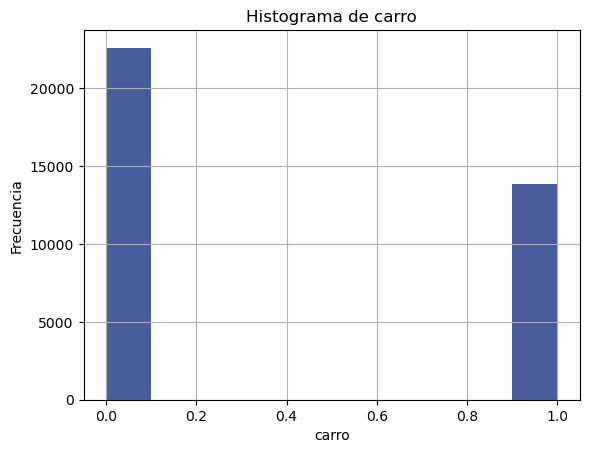

In [70]:
clientes_df["TIENE_CARRO"].hist(bins=10, color=colors)
plt.title("Histograma de carro")
plt.xlabel("carro")
plt.ylabel("Frecuencia")
plt.show()

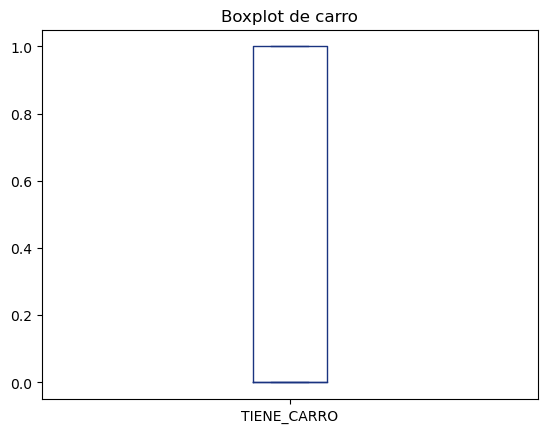

In [75]:
clientes_df['TIENE_CARRO'].plot(kind='box', color=colors)
plt.title('Boxplot de carro')
plt.show()

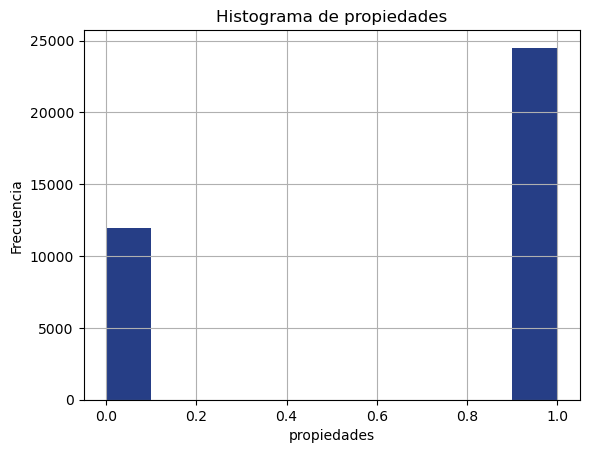

In [76]:
clientes_df["TIENE_PROPIEDADES"].hist(bins=10, color=colors)
plt.title("Histograma de propiedades")
plt.xlabel("propiedades")
plt.ylabel("Frecuencia")
plt.show()

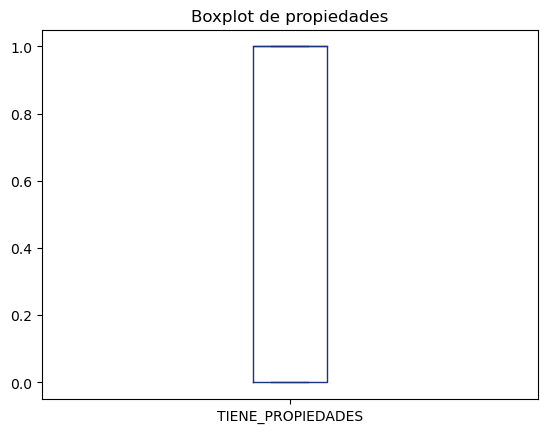

In [77]:
clientes_df['TIENE_PROPIEDADES'].plot(kind='box', color=colors)
plt.title('Boxplot de propiedades')
plt.show()

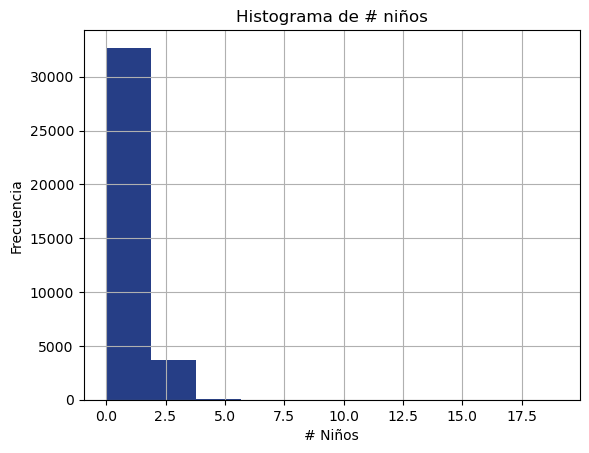

In [78]:
clientes_df["N_NINOS"].hist(bins=10, color=colors)
plt.title("Histograma de # niños")
plt.xlabel("# Niños")
plt.ylabel("Frecuencia")
plt.show()

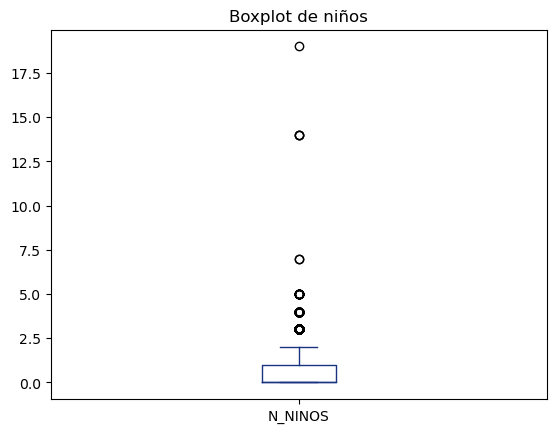

In [79]:
clientes_df['N_NINOS'].plot(kind='box', color=colors)
plt.title('Boxplot de niños')
plt.show()

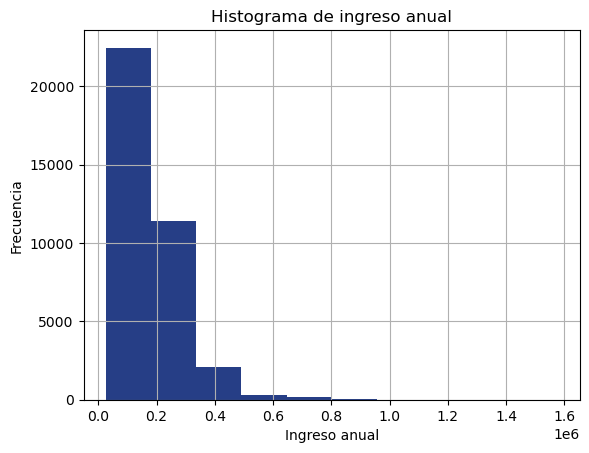

In [80]:
clientes_df["INGRESO_ANUAL"].hist(bins=10, color=colors)
plt.title("Histograma de ingreso anual")
plt.xlabel("Ingreso anual")
plt.ylabel("Frecuencia")
plt.show()

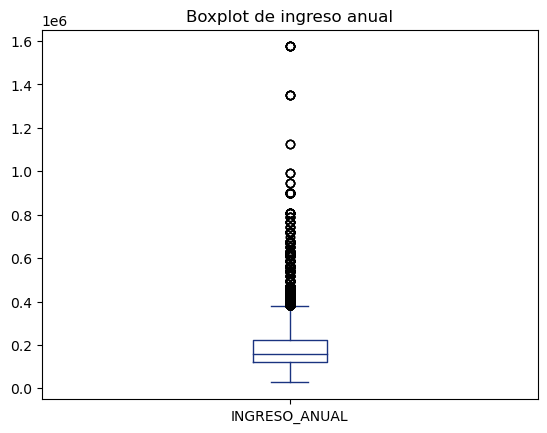

In [81]:
clientes_df['INGRESO_ANUAL'].plot(kind='box', color=colors)
plt.title('Boxplot de ingreso anual')
plt.show()

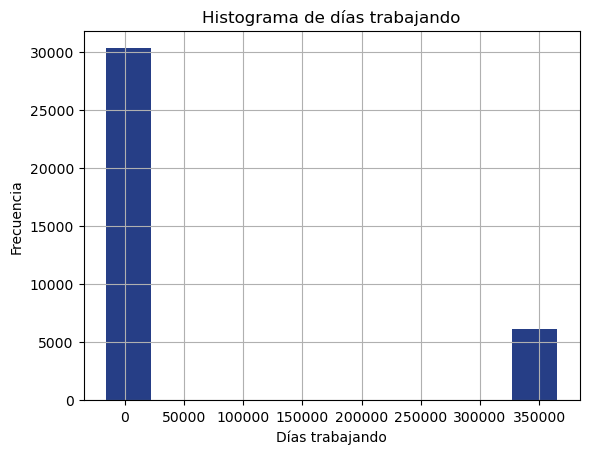

In [82]:
clientes_df["DIAS_TRABAJANDO"].hist(bins=10, color=colors)
plt.title("Histograma de días trabajando")
plt.xlabel("Días trabajando")
plt.ylabel("Frecuencia")
plt.show()

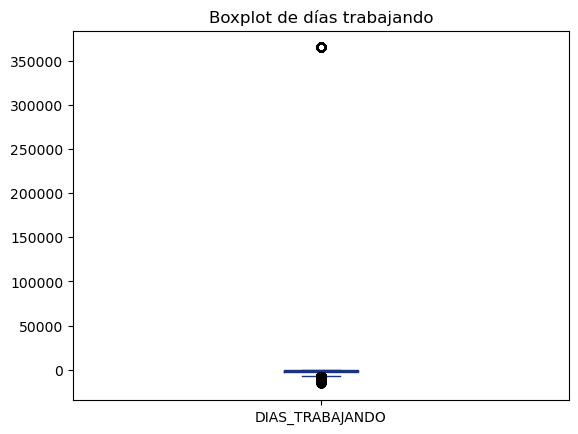

In [83]:
clientes_df['DIAS_TRABAJANDO'].plot(kind='box', color=colors)
plt.title('Boxplot de días trabajando')
plt.show()

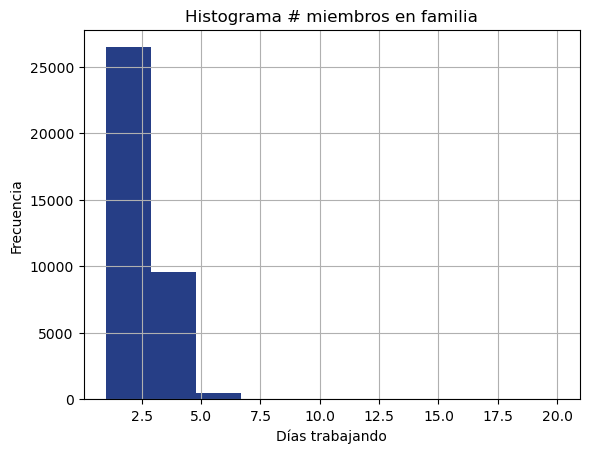

In [84]:
clientes_df["N_MIEMBROSFAMILIA"].hist(bins=10, color=colors)
plt.title("Histograma # miembros en familia")
plt.xlabel("Días trabajando")
plt.ylabel("Frecuencia")
plt.show()

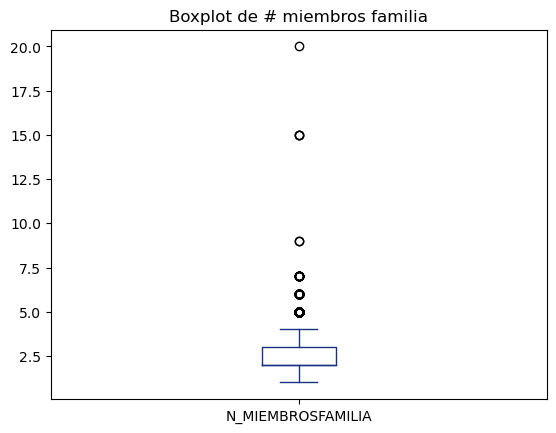

In [85]:
clientes_df['N_MIEMBROSFAMILIA'].plot(kind='box', color=colors)
plt.title('Boxplot de # miembros familia')
plt.show()

In [ ]:
generacion_df = pd.crosstab(clientes_df['GENERACION'], clientes_df["TIPO_CLIENTE"], normalize="index")

In [ ]:
generacion_df.reindex(["Generación Z", "Millennials", "Generación X", "Baby Boomers"])